# Imports and setup

In [1]:
import sys, os
sys.path.append(os.path.realpath(".."))
os.environ["EEG_ROOT"] = "/home/ms994"
import util_funcs
from importlib import reload
reload(util_funcs)
from copy import deepcopy as cp

import data_reader as read
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import pywt
import tsfresh.feature_extraction.feature_calculators as feats
import constants
import clinical_text_analysis as cta
import tsfresh
import ensembleReader as er
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, r2_score
from os import path

import wf_analysis.datasets as wfdata
import wf_analysis.filters as filt
from addict import Dict
import time
import pickle as pkl
import tsfresh.feature_extraction.feature_calculators as tsf
import pyedflib as edf
import seaborn as sns
import multiprocessing as mp
import numpy.random as random
import statsmodels

import keras_models.dataGen as dg

Using Theano backend.


In [2]:
reader = read.EdfDataset("train", "01_tcp_ar", use_numpy=True, n_process=2)

# List of ideas to try out
Longer sequences. It appears that human observers are looking at up to 10+ minutes of EEG data at a time, im only doing 4 second windows in isolation.

See first with hand engineered FFT and coherence features

Also see if i can't include sequences of outputs i.e. t

## Try just doing FNSZ and GNSZ seizure types

## Long sequence

### FFT + Coherence

In [10]:
fft = read.EdfFFTDatasetTransformer(reader, is_pandas_data=False, freq_bins=constants.FREQ_BANDS, window_size=pd.Timedelta(seconds=0.5), )

In [13]:
fftData = fft[0][0]

In [14]:
fftData.shape

(21, 2610, 4)

In [17]:
coherenceReader = wfdata.CoherenceTransformer(reader, is_pandas=False)

### labels

In [3]:
%%bash
cat /home/ms994/v1.5.0/edf/dev_test/01_tcp_ar/002/00000258/s002_2003_07_21/00000258_s002_t002.lbl


version = lbl_v1.0.0

montage = 0, FP1-F7: EEG FP1-REF --  EEG F7-REF
montage = 1, F7-T3:  EEG F7-REF  --  EEG T3-REF
montage = 2, T3-T5:  EEG T3-REF  --  EEG T5-REF
montage = 3, T5-O1:  EEG T5-REF  --  EEG O1-REF
montage = 4, FP2-F8: EEG FP2-REF --  EEG F8-REF
montage = 5, F8-T4:  EEG F8-REF  --  EEG T4-REF
montage = 6, T4-T6:  EEG T4-REF  --  EEG T6-REF
montage = 7, T6-O2:  EEG T6-REF  --  EEG O2-REF
montage = 8, A1-T3:  EEG A1-REF  --  EEG T3-REF
montage = 9, T3-C3:  EEG T3-REF  --  EEG C3-REF
montage = 10, C3-CZ:  EEG C3-REF  --  EEG CZ-REF
montage = 11, CZ-C4:  EEG CZ-REF  --  EEG C4-REF
montage = 12, C4-T4:  EEG C4-REF  --  EEG T4-REF
montage = 13, T4-A2:  EEG T4-REF  --  EEG A2-REF
montage = 14, FP1-F3: EEG FP1-REF --  EEG F3-REF
montage = 15, F3-C3:  EEG F3-REF  --  EEG C3-REF
montage = 16, C3-P3:  EEG C3-REF  --  EEG P3-REF
montage = 17, P3-O1:  EEG P3-REF  --  EEG O1-REF
montage = 18, FP2-F4: EEG FP2-REF --  EEG F4-REF
montage = 19, F4-C4:  EEG F4-REF  --  EEG C4-REF
montage

In [47]:
fn = "/home/ms994/v1.5.0/edf/dev_test/01_tcp_ar/002/00000258/s002_2003_07_21/00000258_s002_t002.edf"
fn[:-4]+".lbl"


'/home/ms994/v1.5.0/edf/dev_test/01_tcp_ar/002/00000258/s002_2003_07_21/00000258_s002_t002'

##### TODO
check that each lbl file has only one level
check that each lbl file is consistent with the tse file

In [56]:
fn = "/home/ms994/v1.5.0/edf/dev_test/01_tcp_ar/002/00000258/s002_2003_07_21/00000258_s002_t002.lbl"
def get_per_channel_annotation(fn):
    with open(fn, "rb") as  open_label_file:
        output = open_label_file.readlines()
    montage_channel_dict = {}
    start_montage_channel_assign = False
    symbols = [None]
    symbols_list = []
    full_list = []
    for line in output:
        if "montage = 0" in str(line):
            start_montage_channel_assign = True
        if start_montage_channel_assign:
            if b'\n' == (line):
                start_montage_channel_assign = False
            else:
                montage_channel_dict[int(line[10:str(line).index(',') - 2])] = (line[str(line).index(','):str(line).index(':') - 2]).decode("utf-8") 
        elif "symbols[0]" in str(line):
            #since we are using weird pseudocode, run the string through exec and get the symbols variable out
            exec(line.decode("utf8"))
            symbols_dict = symbols
            symbols_list = [symbols_dict[0][i] for i in range(len(symbols[0].keys()))]
    #         print(symbols_list)
        elif "label =" in str(line):
#             print(line.decode("utf8").replace("{", "[").replace("}", "]"))
            #since we are using weird pseudocode, run the string through exec and get the label variable out
            label = eval(line.decode("utf8").replace("{", "[").replace("}", "]")[7:])
            
            curr_level = label[0]
            curr_sublevel = label[1]
            curr_start = label[2]
            curr_end = label[3]
            curr_mont_num = label[4]
            curr_channel = montage_channel_dict[int(curr_mont_num)]
            curr_label_probs = label[5]
            curr_vals = pd.Series([curr_level, curr_sublevel, curr_start, curr_end, curr_channel, *curr_label_probs], index=["level", "sublevel", "start", "end", "channel", *symbols_list])
            full_list.append(curr_vals)
#             del label


    return pd.concat(full_list, axis=1).T

In [84]:
data = get_per_channel_annotation(fn)
data

,level,sublevel,start,end,channel,(null),spsw,gped,pled,eyem,...,nesz,intr,slow,eyem,chew,shiv,musc,elpp,elst,calb
0,0,0,0,22.0375,FP1-F7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,22.0375,136.438,FP1-F7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,136.438,272,FP1-F7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,22.0375,F7-T3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,22.0375,136.438,F7-T3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,136.438,272,F7-T3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,22.0375,T3-T5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,22.0375,136.438,T3-T5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,136.438,272,T3-T5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,22.0375,T5-O1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
def gen_seizure_channel_labels(fn, width=pd.Timedelta(seconds=0.5)):
    data = get_per_channel_annotation(fn)
    max_time = pd.Timedelta(seconds=int(data.end.max()))
    index = pd.timedelta_range(start=pd.Timedelta(0), end=max_time, freq=width)
    columns = data.channel.unique()
    expanded_is_seizure = pd.DataFrame(index=index, columns=columns).fillna(0)
    for i, row in data.iterrows():
        expanded_is_seizure.loc[pd.Timedelta(seconds=row.start):pd.Timedelta(seconds=row.end), row.channel] = 1 - row.bckg
    return expanded_is_seizure

In [79]:
edf_files = read.get_all_token_file_names("train", "01_tcp_ar")
reload(read)
lbl_files = [read.get_associated_lbl(fn) for fn in edf_files]

In [80]:
all_channels = set()
len_channels = set()
for lbl_fn in lbl_files:
    all_channels = all_channels.union(read.get_per_channel_annotation(lbl_fn).channel.unique())
    len_channels.add(len(read.get_per_channel_annotation(lbl_fn).channel.unique()))

In [81]:
edf_files = read.get_all_token_file_names("dev_test", "01_tcp_ar")
reload(read)
lbl_files = [read.get_associated_lbl(fn) for fn in edf_files]
for lbl_fn in lbl_files:
    all_channels = all_channels.union(read.get_per_channel_annotation(lbl_fn).channel.unique())
    len_channels.add(len(read.get_per_channel_annotation(lbl_fn).channel.unique()))

In [82]:
list(all_channels)

['C3-CZ',
 'CZ-C4',
 'FP1-F7',
 'F8-T4',
 'F7-T3',
 'C4-T4',
 'FP2-F4',
 'T5-O1',
 'C4-P4',
 'F3-C3',
 'T3-T5',
 'A1-T3',
 'T4-A2',
 'FP2-F8',
 'FP1-F3',
 'T3-C3',
 'C3-P3',
 'T4-T6',
 'P4-O2',
 'P3-O1',
 'T6-O2',
 'F4-C4']

In [83]:
list(len_channels)

[22]

In [53]:
util_funcs.get_common_channel_names()

['EEG T5-REF',
 'EEG C3-REF',
 'EEG A1-REF',
 'EEG P4-REF',
 'EEG F8-REF',
 'EEG F3-REF',
 'EEG CZ-REF',
 'EEG O2-REF',
 'EEG A2-REF',
 'EEG P3-REF',
 'EEG C4-REF',
 'EEG O1-REF',
 'EEG T4-REF',
 'EEG F4-REF',
 'EEG F7-REF',
 'EEG PZ-REF',
 'EEG FP1-REF',
 'EEG FZ-REF',
 'EEG T3-REF',
 'EEG T6-REF',
 'EEG FP2-REF']

In [58]:
gen_seizure_channel_labels(fn).columns

Index(['FP1-F7', 'F7-T3', 'T3-T5', 'T5-O1', 'FP2-F8', 'F8-T4', 'T4-T6',
       'T6-O2', 'A1-T3', 'T3-C3', 'C3-CZ', 'CZ-C4', 'C4-T4', 'T4-A2', 'FP1-F3',
       'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2'],
      dtype='object')

In [27]:
data_x = reader[0][0]

In [34]:
constants.COMMON_DELTA

0.004

### Data Binning

In [3]:
def time_distribute_x(data_x, width=pd.Timedelta(seconds=4), stride=pd.Timedelta(seconds=1)):
    time_steps = []
    literal_width = int(width/pd.Timedelta(seconds=constants.COMMON_DELTA))
    literal_stride = int(stride/pd.Timedelta(seconds=constants.COMMON_DELTA))
    for i in range(int(data_x.shape[0]/literal_stride - width/stride)):
        time_steps.append(data_x[i*literal_stride:(i) * literal_stride + literal_width])
    time_steps = np.array(time_steps)
    return time_steps

In [51]:
time_distribute_x(data_x).shape

(1301, 1000, 21)

In [15]:
len(reader.edf_tokens)

3177

In [ ]:
modify_self()

In [67]:
class LSTMDataset(util_funcs.MultiProcessingDataset):
    def __init__(self, reader, width=pd.Timedelta(seconds=4), stride=pd.Timedelta(seconds=2)):
        self.width = width
        self.stride = stride
        self.reader = reader
    def __len__(self):
        return len(self.reader)
    def __getitem__(self, i):
        if self.should_use_mp(i):
            return self.getItemSlice(i)
        data_x, labels = self.reader[i]
        data_x = read.time_distribute_x(data_x, width=self.width, stride=self.stride)
        return data_x, read.expand_tse_file_seizure_only(labels, time_period=self.stride).iloc[0:data_x.shape[0]]
        

In [81]:
reload(read)
reload(lstm_model)
import keras_models.LSTMModels as lstm_model
lstm_data = lstm_model.LSTMDataset(reader)

In [69]:
reader[10][0].shape

(150240, 21)

In [70]:
150240/(250)/60

10.016

In [8]:
dp = lstm_data[10]

In [9]:
dp[0].shape

(298, 1000, 21)

In [9]:
import sys

sys.getsizeof(data[0])

218568128

In [13]:
stride = lstm_data.stride
labels = reader[0][1]
index = pd.timedelta_range(start=pd.Timedelta(0), end=pd.Timedelta(seconds=labels.end.max()), freq=stride)


In [27]:
reload(read)
seiz_series = read.expand_tse_file_seizure_only(labels)

# CNN + LSTM

In [101]:
from keras import optimizers
from keras.layers import Masking, Dense, TimeDistributed, Input, Reshape, Dropout, LSTM, Flatten, MaxPool2D, Concatenate, CuDNNLSTM, Conv2D, BatchNormalization
from keras.models import Model, load_model
from keras.utils import multi_gpu_model

In [145]:
x = Input(shape=(None, 1000, 21, 1))
y = x
# y = Masking(edg.mask_value)(y)
for i in range(6):
    y = TimeDistributed(BatchNormalization())(y)
    y = TimeDistributed(Conv2D(1, (4,4), activation="relu"))(y)
    y = TimeDistributed(MaxPool2D((2,1)))(y)
y = Reshape((-1, y.shape[2].value * y.shape[3].value * y.shape[4].value))(y)
y = CuDNNLSTM(y.shape[-1].value, return_sequences=True)(y)
for i in range(1):
    y = TimeDistributed(Dense(y.shape[-1].value, activation="relu"))(y)
    y = TimeDistributed(Dropout(0.5))(y)
y = TimeDistributed(Dense(2, activation="relu"))(y)
y = Reshape((-1, 2, 1))(y)


model = Model(inputs=x, outputs=[y])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_55 (InputLayer)        (None, None, 1000, 21, 1) 0         
_________________________________________________________________
time_distributed_840 (TimeDi (None, None, 1000, 21, 1) 4         
_________________________________________________________________
time_distributed_841 (TimeDi (None, None, 997, 18, 1)  17        
_________________________________________________________________
time_distributed_842 (TimeDi (None, None, 498, 18, 1)  0         
_________________________________________________________________
time_distributed_843 (TimeDi (None, None, 498, 18, 1)  4         
_________________________________________________________________
time_distributed_844 (TimeDi (None, None, 495, 15, 1)  17        
_________________________________________________________________
time_distributed_845 (TimeDi (None, None, 247, 15, 1)  0         
__________

In [85]:
lstm_data[10][0].shape

(298, 1000, 21)

In [153]:
lstm_data.use_mp = False

In [154]:
reload(dg)
edg = dg.EdfDataGenerator(lstm_data, batch_size=16, n_classes=2, class_type="custom")
edg.transform_y = lambda ys: dg.three_dim_pad([y.values for y in ys], mask_value=edg.mask_value)

In [105]:
batch_1 = edg[0]

Starting 4 processes


In [147]:
edg[0]

(1, 3, 1000, 21, 1)

In [155]:
model.compile("adam", loss="binary_crossentropy")
history = model.fit_generator(edg, steps_per_epoch=100, use_multiprocessing=True, workers=5, max_queue_size=4)

Epoch 1/1


Process ForkPoolWorker-204:
Process ForkPoolWorker-206:
Process ForkPoolWorker-205:
Process ForkPoolWorker-200:
Process ForkPoolWorker-203:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ms994/miniconda3/envs/kera

KeyboardInterrupt: 

In [150]:
history.history

{'loss': [4.017263412475586]}

In [125]:
batch = edg[0]

Starting 4 processes


In [141]:
lstm_data[1613][1].shape

(3, 2)

In [129]:
batch[1].shape

(1, 3, 2, 1)

# Try doing some hand engineered features

## Try pulling debug data and doing the hand-engineered features

In [2]:
debug_train = pkl.load(open("/home/ms994/debug_train_multiple_labels_seizure_data_4.pkl", "rb"))

In [3]:
debug_train[0]

(array([[ 6.02720597e-01,  5.18369545e-02,  6.93890635e-01, ...,
          3.57024951e-01,  2.54265447e-01, -5.34651391e+00],
        [ 4.08195355e+00,  3.29598969e-01,  4.64492085e+00, ...,
          2.34079393e+00,  1.69027318e+00, -3.65963169e+01],
        [ 1.22471327e+01,  9.56127637e-01,  1.36964752e+01, ...,
          6.70254507e+00,  4.82848564e+00, -1.11716027e+02],
        ...,
        [-2.62819352e+01, -8.51805643e+00, -2.20238865e+01, ...,
         -1.55604969e+01, -2.04403041e+01,  1.99636611e+01],
        [-3.19603814e+01, -1.05098869e+01, -2.85798836e+01, ...,
         -1.88502179e+01, -2.26238761e+01, -6.69465470e+00],
        [-3.97333048e+01, -1.22024774e+01, -3.44020055e+01, ...,
         -2.34132684e+01, -2.83107976e+01, -3.16201816e+01]]),
 (False, '00013182/s001_2015_10_07', 0, C3-CZ     0.0
  CZ-C4     0.0
  FP1-F7    0.0
  F8-T4     0.0
  F7-T3     0.0
  C4-T4     0.0
  FP2-F4    0.0
  T5-O1     0.0
  C4-P4     0.0
  F3-C3     0.0
  T3-T5     0.0
  A1-T3     0.0

In [123]:
fftData = read.EdfFFTDatasetTransformer(debug_train, is_tuple_data=True, is_pandas_data=False, freq_bins=constants.FREQ_BANDS, window_size=pd.Timedelta(seconds=1), )[0]

In [125]:
fftData[0].shape

(21, 4, 4)

In [20]:
coherData.edfRawData[0][0].shape

(1000, 21)

In [120]:
reload(wfdata)
coherData = wfdata.CoherenceTransformer(debug_train, is_pandas=False, is_tuple_data=True, average_coherence=False, coherence_bin=pd.Timedelta(seconds=1))

In [122]:
coherData[10][0].shape

(4, 210)

In [101]:
from scipy.signal import coherence

In [116]:
coherence(coherData.edfRawData[10][0][0:500,0], coherData.edfRawData[10][0][0:500,2])[1]

array([0.17799238, 0.90452412, 0.97399404, 0.23590005, 0.08287945,
       0.72522799, 0.71073161, 0.87015426, 0.29553472, 0.77445354,
       0.04992193, 0.05962091, 0.30201608, 0.5159357 , 0.09767354,
       0.37904122, 0.95720845, 0.44621864, 0.89495525, 0.05906153,
       0.27833211, 0.58499167, 0.63293755, 0.42380637, 0.29958268,
       0.71163305, 0.64138525, 0.40930195, 0.18771567, 0.5608435 ,
       0.45561666, 0.96355856, 0.78565086, 0.5927573 , 0.09366734,
       0.36290704, 0.2597338 , 0.49249428, 0.53523139, 0.60815817,
       0.58459677, 0.267558  , 0.13148104, 0.58213079, 0.93162997,
       0.46958298, 0.19109801, 0.85372972, 0.86613531, 0.72137104,
       0.88368131, 0.11170762, 0.21816379, 0.63027687, 0.6275261 ,
       0.73143274, 0.42350259, 0.04477435, 0.25017242, 0.54046276,
       0.42447015, 0.78203036, 0.36602084, 0.5440614 , 0.86832654,
       0.90179172, 0.03358346, 0.67031211, 0.84141945, 0.15287424,
       0.07371516, 0.47618351, 0.73714206, 0.87211327, 0.93487

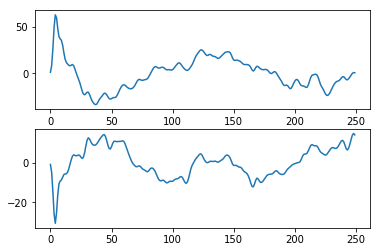

In [110]:
plt.subplot(2,1,1)
plt.plot(coherData.edfRawData[10][0][0:250,0])
plt.subplot(2,1,2)

plt.plot(coherData.edfRawData[10][0][0:250,1])


In [40]:
datum

array([[4.94065646e-324, 6.91991307e-310, 4.94065646e-324, ...,
        2.92621864e-014, 2.98407328e-260, 6.01347002e-154],
       [5.03736098e+180, 6.01347002e-154, 6.01347002e-154, ...,
        7.34631168e+223, 3.95609959e+252, 7.50187034e+247],
       [4.24819625e+180, 5.98131455e-154, 2.13521639e+185, ...,
        6.47522084e+170, 1.44723336e+166, 1.20657714e+285],
       ...,
       [2.11329293e+214, 3.05174459e+169, 1.37030444e-153, ...,
        3.60687650e+198, 1.10634595e+200, 4.71294511e+257],
       [3.93197576e-244, 6.01347002e-154, 6.01347002e-154, ...,
        6.73547815e-244, 1.99416198e+174, 6.19517785e+223],
       [2.98368858e-109, 6.01347002e-154, 2.28896110e+243, ...,
        1.79209551e-313, 1.70358642e+222, 4.82149412e+151]])

In [51]:
coherData[0].shape

(8, 210)

In [72]:
fftData[0].shape

(21, 8, 4)

In [76]:
wfdata.ConcatenationDataset([fftData, coherData])[1]

AttributeError: 'bool' object has no attribute 'flatten'

In [35]:
coherData.coherence_bin / pd.Timedelta(seconds=constants.COMMON_DELTA)

125.0

In [16]:
debug_train[0][0].shape

(1000, 21)